# Does the GBIF DWCA/EMAIL Method Work?

The following code can be edited with your notebook's name and run in command line in order to generate output without the input code:

jupyter nbconvert --to html --TemplateExporter.exclude_input=True --output-dir="T:/Temp/" NOTEBOOKNAMEHERE.ipynb

In [1]:
# Specify some paths and names in the cell below.
config_path = "T:/Data/"  # Path to folder where you saved your wildlifeconfig file.
filter_set_json = None
taxon_json = None
query_name = 'DWCA_TEST'
ask_eBird = False
ask_GBIF = True

In [2]:
# Nothing to fill out in the next cell
%matplotlib inline
import os
import sqlite3
import pprint
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
sys.path.append(config_path)
import wranglerconfig as config
sys.path.append(config.codeDir)
import wrangler_functions as functions

# Define some variables
t1 = datetime.now()
working_directory = config.workDir
username = config.gbif_username
password = config.gbif_password
email = config.gbif_email
EBD_file = config.EBD_file
output_database = working_directory + query_name + '.sqlite'

# Set display options
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_rows', 150)

print("Notebook run " + str(t1))
print("Results were saved in " + output_database)

Notebook run 2021-06-08 09:50:22.350131
Results were saved in T:/Occurrence_Records/DWCA_TEST.sqlite


## Taxon Concept
Caution! -- Taxon concept mismatches can cause inclusion of innapropriate records or ommission of useful records.

In [3]:
your_taxon_id = "TestCuckoo"
gbif_id = 2496287 
ebird_id = "Yellow-billed Cuckoo"
detection_distance_m = 200
taxon_polygon = None

In [4]:
# If a json was provided, use it, otherwise create a new one with info that was provided.
if taxon_json is None:
    # Build a species dictionary
    taxon_info = {"ID": your_taxon_id, "GBIF_ID": gbif_id, "EBIRD_ID": ebird_id, "detection_distance_m": detection_distance_m,
                  "TAXON_EOO": taxon_polygon}

    # Save as json object
    out_file = open(working_directory + your_taxon_id + ".json", "w")  
    json.dump(taxon_info, out_file) 
    out_file.close() 

if taxon_json is not None:
    with open(taxon_json, "r") as f:
        taxon_info = json.load(f)
        f.close()
        
pprint.pprint(taxon_info)

{'EBIRD_ID': 'Yellow-billed Cuckoo',
 'GBIF_ID': 2496287,
 'ID': 'TestCuckoo',
 'TAXON_EOO': None,
 'detection_distance_m': 200}


## Filter Set
Specify how you want records filtered and cleaned.  Alternatively, you can load a filter set here by specifying a path in the first cell of this notebook.  

To skip a filter, enter "None" without the quotation marks or "".  

In [5]:
filter_set_name = "test_dwca_1"
print("Filter set name: " + str(filter_set_name))

Filter set name: test_dwca_1


#### GBIF Request Method

In [6]:
"""
Whether to get records from GBIF in a darwin core archive.  
"False" uses the GBIF API, which has limitations that may be important.  
"True" requests results be emailed in a darwin core archive.
"""
get_dwca = True 
print("Request a Darwin Core Archive? " + str(get_dwca))

Request a Darwin Core Archive? True


#### Date Limits
Notes: 

In [7]:
'''
Enter year and month ranges.  For example, years_range = 2015,2017 and months_range = 3,6
'''
years_range = "2011,2020"
months_range = "6,8"
print("Years: " + str(years_range))
print("Months: " + str(months_range))

Years: 2011,2020
Months: 6,8


#### Country
Notes:

In [8]:
country = "US"
print("Country: " + country)

Country: US


#### Bounding Box
Notes:

In [9]:
'''
Coordinates should correspond to WGS84 (EPSG:4326).  Don't use this option if you specify a query polygon below.
'''
lat_range = "30,35"
lon_range = "-89,-75"
print("Latitude range: " + lat_range)
print("Longitude range: " + lon_range)

Latitude range: 30,35
Longitude range: -89,-75


#### Area of Interest
Notes:

In [10]:
'''
Specify polygons to use for spatial filtering.  
Records with coordinates outside of the polygons will be removed.  
You can specify a geometry for the query and one for the species.  
The species geometry is included to facilitate better handling of taxonomic issues.  
If both are provided, the intersection is calculated and used as the filter.  
The format should be well known text in WGS84 (EPSG 4326), and very importantly, vertices need to be listed counter-clockwise.  
See the ccw_wkt_from_shp() function in wrangler functions for help.
'''
query_polygon = None
print(query_polygon)

None


#### Taxon EOO
Notes:

In [11]:
'''
True or False whether you want to apply the taxon EOO to the filtering.  
If True, removes records with centroids outside of the extent of occurrence geometry you provided in taxon_info.
'''
use_taxon_geometry = False
print("Use taxon extent of occurrence? " + str(use_taxon_geometry))

Use taxon extent of occurrence? False


#### Geoissue
Notes:

In [12]:
'''
Are GBIF records with noted geoissues OK to include? GBIF only.
'''
geoissue = None
print("Records with geoissues OK? " + str(geoissue))

Records with geoissues OK? None


#### Collections
Notes:

In [13]:
'''
List collection codes that you'd like to omit. GBIF only.
'''
collection_codes_omit = None
print("Omit: " + str(collection_codes_omit))

Omit: None


#### Institutions
Notes:

In [14]:
'''
List institution codes that you'd like to omit. GBIF only
'''
institutions_omit = None
print("Omit: " + str(institutions_omit))

Omit: None


#### Datasets
Notes:

In [15]:
'''
List datasets that you'd like to omit.
'''
datasets_omit = None
print("Omit: " + str(datasets_omit))

Omit: None


#### Coordinate Uncertainty
Notes:

In [16]:
'''
Do you want to remove records without coordinate uncertainty (1) or leave them in the data set (0)?  
Note that eBird records in GBIF (EOD) do not have this and neither do data in the EBD dataset.  
With the EBD, the length of traveling counts is used as a surrogate value.  

max_coordinate_uncertainty must be an integer greater than 0.

default_coordUncertainty -- coordinateUncertaintyInMeters is often not provided.  
Here is an option to use a default.  If you don't want anything entered, set this equal to False (boolean, not string).

A maximum for coordinate uncertainty can also be set in meters.
'''
has_coordinate_uncertainty = False
default_coordUncertainty = 1000
max_coordinate_uncertainty = 10000
print("Coordinate uncertainty required? " + str(has_coordinate_uncertainty))
print("Default coordinate uncertainty to use: " + str(default_coordUncertainty))
print("Maximum allowable coordinate uncertainty: " + str(max_coordinate_uncertainty))

Coordinate uncertainty required? False
Default coordinate uncertainty to use: 1000
Maximum allowable coordinate uncertainty: 10000


#### Bases
Notes:

In [17]:
'''
List bases of records that you want to omit.  GBIF only.
'''
bases_omit = None
print("Omit: " + str(bases_omit))

Omit: None


#### Sampling Protocols
Notes:

In [18]:
'''
List sampling protocols that you would like to omit.
'''
sampling_protocols_omit = None
print("Omit: " + str(sampling_protocols_omit))

Omit: None


#### Issues
Notes:

In [19]:
'''
List issues that you want to omit.  GBIF only.
'''
issues_omit = None
print("Omit: " + str(issues_omit))

Omit: None


#### Duplicates
Notes:

In [20]:
'''
Specify whether duplicates on latitude, longitude, and date should be included.
'''
duplicates_OK = True
print("Allow duplicates? " + str(duplicates_OK))

Allow duplicates? True


#### Filter Set Summary

In [21]:
if filter_set_json is None:
    # Build a filter set dictionary
    filter_set = {"name": filter_set_name, "query_polygon": query_polygon, "issues_omit": issues_omit,
                  "sampling_protocols_omit": sampling_protocols_omit, "bases_omit": bases_omit,
                  "has_coordinate_uncertainty": has_coordinate_uncertainty, "geoissue": geoissue,
                  "default_coordUncertainty": default_coordUncertainty,
                  "max_coordinate_uncertainty": max_coordinate_uncertainty,
                  "datasets_omit": datasets_omit, "collection_codes_omit": collection_codes_omit,
                  "institutions_omit": institutions_omit, "geoissue": geoissue, "use_taxon_geometry": use_taxon_geometry,
                  "lat_range": lat_range, "lon_range": lon_range, "country": country, 
                  "years_range": years_range, "months_range": months_range, "duplicates_OK": duplicates_OK, "get_dwca": get_dwca}
    
    # Replace empty strings with None
    for x in filter_set.keys():
        if filter_set[x] == "":
            filter_set[x] = None
    
    # Save as json object
    with open(working_directory + filter_set_name + ".json", "w") as f:
        json.dump(filter_set, f) 
        f.close()
        
if filter_set_json is not None:
    with open(filter_set_json, "r") as f:
        filter_set = json.load(f)
        f.close()
        
    # Replace empty strings with None
    for x in filter_set.keys():
        if filter_set[x] == "":
            filter_set[x] = None
        
pprint.pprint(filter_set)

{'bases_omit': None,
 'collection_codes_omit': None,
 'country': 'US',
 'datasets_omit': None,
 'default_coordUncertainty': 1000,
 'duplicates_OK': True,
 'geoissue': None,
 'get_dwca': True,
 'has_coordinate_uncertainty': False,
 'institutions_omit': None,
 'issues_omit': None,
 'lat_range': '30,35',
 'lon_range': '-89,-75',
 'max_coordinate_uncertainty': 10000,
 'months_range': '6,8',
 'name': 'test_dwca_1',
 'query_polygon': None,
 'sampling_protocols_omit': None,
 'use_taxon_geometry': False,
 'years_range': '2011,2020'}


## Processing

In [22]:
# Create an output database
functions.build_output_database(output_database)

# Save taxon and filter set info into database
output_db_conn= sqlite3.connect(output_database)
cursor = output_db_conn.cursor()
pd.DataFrame(taxon_info.values(), taxon_info.keys()).applymap(str).to_sql(name='taxon_concept', con=output_db_conn, if_exists='replace')
pd.DataFrame(filter_set.values(), filter_set.keys()).applymap(str).to_sql(name='filter_set', con=output_db_conn, if_exists='replace')
output_db_conn.close()

In [23]:
# Run the appropriate queries
if ask_eBird == True and ask_GBIF == True:
    # Run eBird query
    ebird_data = functions.get_EBD_records(taxon_info, filter_set, working_directory, EBD_file, query_name)
    # Run GBIF query
    gbif_data = functions.get_GBIF_records(taxon_info, filter_set, query_name, working_directory, username, password, email) 

elif ask_eBird == True and ask_GBIF == False:
    # Run eBird query
    ebird_data = functions.get_EBD_records(taxon_info, filter_set, working_directory, EBD_file, query_name)
    gbif_data = None

elif ask_eBird == False and ask_GBIF == True:
    # Run GBIF query
    gbif_data = functions.get_GBIF_records(taxon_info, filter_set, query_name, working_directory, username, password, email)
    ebird_data = None

Prepard filter set and sorted out geometry constraints: 0:00:00
22423 records available
['taxonKey = 2496287', 'hasCoordinate = True', 'country = US', 'year >= 2011', 'year <= 2020', 'month >= 6', 'month <= 8', 'decimalLatitude >= 30', 'decimalLatitude <= 35', 'decimalLongitude >= -89', 'decimalLongitude <= -75']
Your download key is  0297512-200613084148143
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391

Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file 

Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file 

Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file 

Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file size: 2915391 bytes
Download file 

In [24]:
# Filter out records with undesirable values, locations, and/or duplication.
#import importlib
#importlib.reload(functions)
for x in filter_set.keys():
    if filter_set[x] == "":
        filter_set[x] = None

In [25]:
functions.process_records(ebird_data=ebird_data, gbif_data=gbif_data, filter_set=filter_set, 
                        taxon_info=taxon_info, working_directory=working_directory, 
                        query_name=query_name)

Prepared data frames for processing: 0:00:00.047479
Summarized values acquired: 0:00:00.119671
Number of georeferenced records: 37
Number of record without georeference: 22386
Applying default coordinate uncertainties
Prepared and georeferenced records:0:00:00.112866
Performed filtering: 0:00:00.234114
DUPLICATES ON LATITUDE, LONGITUDE, DATE-TIME INCLUDED
Saved summary of filtering results: 0:00:00.160907


In [26]:
output_db_conn= sqlite3.connect(output_database)
cursor = output_db_conn.cursor()
record_count = cursor.execute("SELECT COUNT(record_id) FROM occurrence_records;").fetchone()
print(str(record_count[0]) + " records were saved in the output database")

22421 records were saved in the output database


## Results of the Filtering

#### Attributes Returned for GBIF Records
This count was made before filters were applied

In [27]:
if ask_GBIF == True:
    fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", output_db_conn)
    fields_summary.index.name = 'Field'
    pd.set_option('display.max_rows', 250)
    print(fields_summary.sort_values(by="attribute"))
if ask_GBIF == False:
    print("GBIF was not queried.")

                                 attribute  included(n)  populated(n)
Field                                                                
0                                 abstract        22423             0
182                      acceptedNameUsage        22423             0
175                    acceptedNameUsageID        22423             0
230                 acceptedScientificName        22423         22423
219                       acceptedTaxonKey        22423         22423
1                             accessRights        22423             0
2                            accrualMethod        22423             0
3                       accrualPeriodicity        22423             0
4                            accrualPolicy        22423             0
5                              alternative        22423             0
89                   associatedOccurrences        22423             0
90                     associatedOrganisms        22423             0
81                  

#### Attributes Returned for eBird Records
This count was made before filters were applied

In [28]:
if ask_eBird == True:
    fields_summary = pd.read_sql("SELECT * FROM ebird_fields_returned", output_db_conn)
    fields_summary.index.name = 'Field'
    pd.set_option('display.max_rows', 250)
    print(fields_summary)
if ask_eBird == False:
    print("No eBird Basic Dataset was queried.")

No eBird Basic Dataset was queried.


#### Sources

In [29]:
sources = pd.read_sql(sql="SELECT * FROM sources;", con=output_db_conn)
print(sources[['institutionID', 'collectionCode', 'datasetName', 'acquired', 'removed', 'retained']])

   institutionID  collectionCode                              datasetName  acquired  removed  retained
0            nan     Bird sounds                                      nan         2        0         2
1            nan           EBIRD                                      nan     22199        0     22199
2            nan        EBIRD_AK                                      nan         2        0         2
3            nan    EBIRD_ATL_VA                                      nan         1        0         1
4            nan    EBIRD_ATL_WI                                      nan         1        0         1
5            nan        EBIRD_AU                                      nan         1        0         1
6            nan       EBIRD_BRA                                      nan        65        0        65
7            nan  EBIRD_CAMERICA                                      nan        15        0        15
8            nan       EBIRD_CAN                                      nan

#### Bases

In [30]:
bases = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'basisOfRecord';", con=output_db_conn)
print(bases[['value', 'acquired', 'removed', 'retained']])

               value  acquired  removed  retained
0  HUMAN_OBSERVATION     22423        2     22421


#### Protocols

In [31]:
protocols = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'samplingProtocol';", con=output_db_conn)
if protocols.empty == True:
    print("No protocols were documented.")
if protocols.empty == False:
    print(protocols[['value', 'acquired', 'removed', 'retained']])

  value  acquired  removed  retained
0   nan     22423        2     22421


#### Issues

In [32]:
issues = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'issues';", con=output_db_conn)
if issues.empty == True:
    print("No issues were documented.")
if issues.empty == False:
    print(issues[['value', 'acquired', 'removed', 'retained']])

                                                                             value  acquired  removed  retained
0                                    COLLECTION_MATCH_NONE;INSTITUTION_MATCH_FUZZY     22379        0     22379
1                                  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84        34        2        32
2  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_UNCERTAINTY_METER...         2        0         2
3                                                     GEODETIC_DATUM_ASSUMED_WGS84         6        0         6
4                                                                              nan         2        0         2


#### Establishment Means

In [33]:
establishment = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'establishmentMeans';", con=output_db_conn)
if establishment.empty == True:
    print("No establishment means were reported.")
if establishment.empty == False:
    print(establishment[['value', 'acquired', 'removed', 'retained']])

  value  acquired  removed  retained
0   nan     22423        2     22421


#### Identification Qualifiers

In [34]:
qualifications = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'identificationQualifers';", con=output_db_conn)
if qualifications.empty == True:
    print("No identification qualifiers were reported.")
if qualifications.empty == False:
    print(establishment[['value', 'acquired', 'removed', 'retained']])

No identification qualifiers were reported.


## Descriptions of Retained Records

#### Locations

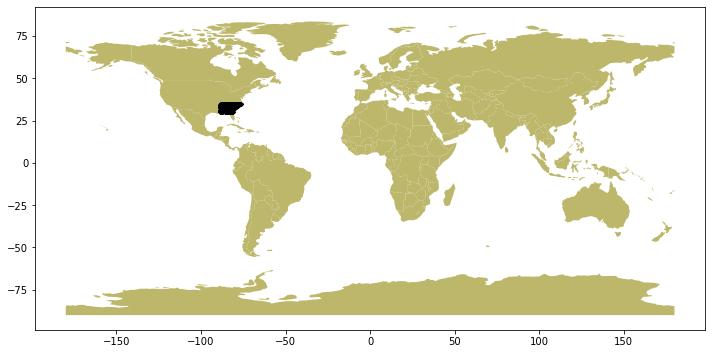

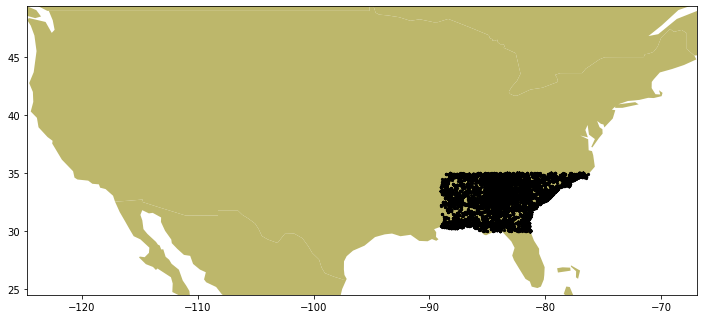

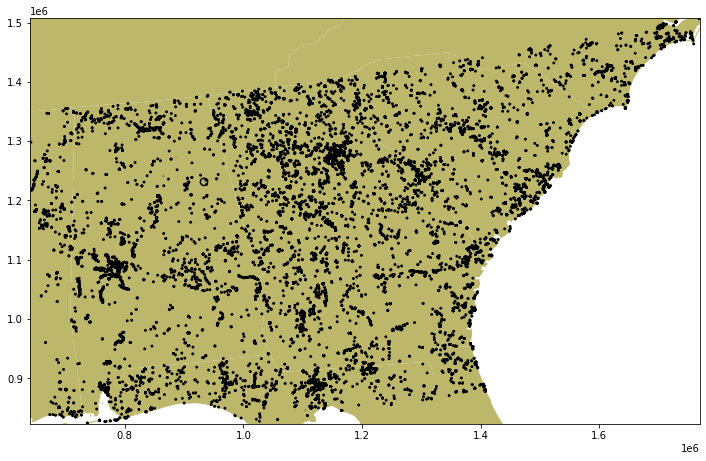

In [35]:
# Get the record coordinates as a data frame
record_coordinates = (pd.read_sql("""SELECT decimalLatitude, decimalLongitude, radius_meters
                                     FROM occurrence_records""",
                                  con=output_db_conn)
                      .astype({'decimalLongitude': 'float', 'decimalLatitude': 'float',
                               'radius_meters': 'float'}))

# Make the data frame spatial
gdf = gpd.GeoDataFrame(record_coordinates, geometry=gpd.points_from_xy(record_coordinates['decimalLongitude'],
                                                   record_coordinates['decimalLatitude']))

# Set the coordinate reference system
gdf.crs={'init' :'epsg:4326'}

# Create world map <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(figsize=(12,12), color = 'darkkhaki')
gdf.plot(ax=base, marker='o', color='k', markersize=5)
plt.show()

# Create USA map <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
if filter_set["country"] == "US":
    usa_bbox = np.array([-124.725839,   24.498131,  -66.949895,   49.384358])
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xlim(([usa_bbox[0],  usa_bbox[2]]))
    ax.set_ylim(([usa_bbox[1],  usa_bbox[3]]))
    world.plot(ax=ax, color='darkkhaki')
    gdf.plot(ax=ax, marker='o', color='k', markersize=5)
    plt.show()

# Create coordinate extent map <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
os.chdir(config.codeDir)
states = gpd.read_file(os.getcwd() + '/data/us_states.shp')

# Reproject states and record coordinates to facilitate buffering
states = states.to_crs(epsg=5070)
footprints = gdf.to_crs(epsg=5070)

# Buffer points for record footprints
footprints['footprint']=footprints.apply(lambda x: x.geometry.buffer(x.radius_meters), axis=1)
footprints.set_geometry(col='footprint', inplace=True, drop=True)

# Map the buffered points/footprints
fig, ax = plt.subplots(figsize=(12,12))
coordinate_bbox = footprints.geometry.total_bounds
ax.set_xlim(([coordinate_bbox[0],  coordinate_bbox[2]]))
ax.set_ylim(([coordinate_bbox[1],  coordinate_bbox[3]]))
states.plot(ax=ax, color = 'darkkhaki')
footprints.boundary.plot(ax=ax, color='k')
plt.show()

# Cleanup
del footprints, gdf

#### Years Represented

Text(0.5, 1.0, 'Occurrences per Year')

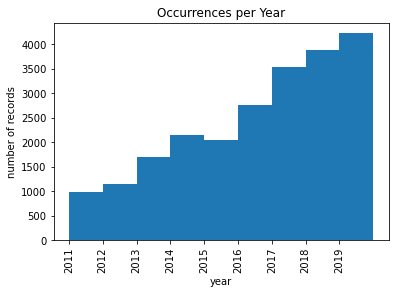

In [36]:
occ_years = [int(x[0]) for x in cursor.execute("SELECT strftime('%Y', eventDate) FROM occurrence_records").fetchall()]
years = filter_set['years_range']
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of records")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

#### Months Represented

Text(0.5, 1.0, 'Occurrences per Month')

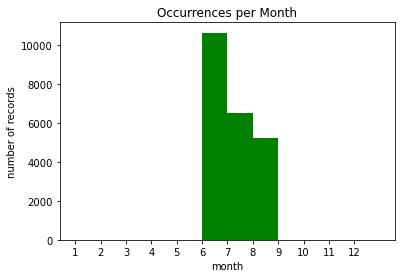

In [37]:
occ_months = [int(x[0]) for x in cursor.execute("SELECT strftime('%m', eventDate) FROM occurrence_records").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of records")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

#### Distribution of Coordinate Uncertainty Values for Retained Records

Text(0.5, 1.0, 'Coordinate Uncertainty')

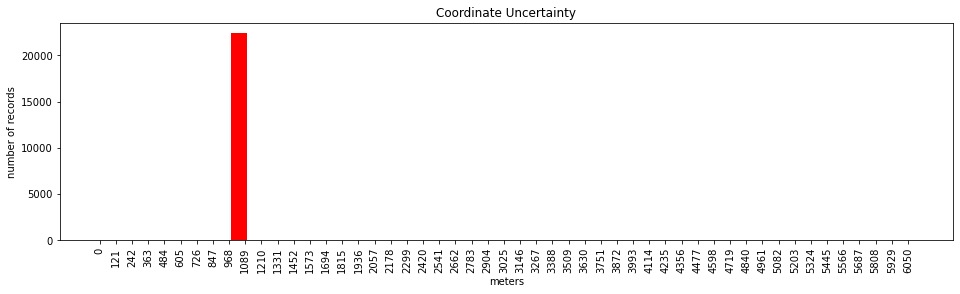

In [38]:
occ_cert = [float(x[0]) for x in cursor.execute("SELECT coordinateUncertaintyInMeters FROM occurrence_records").fetchall()]
maxi = max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, int(maxi), int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("meters")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty')

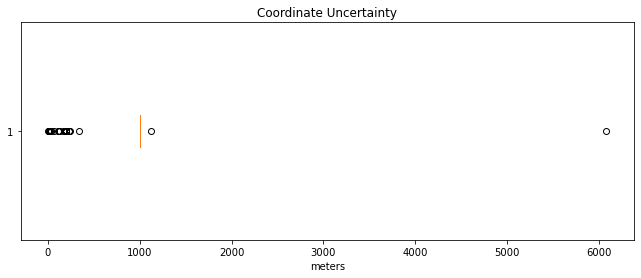

In [39]:
occ_cert = [float(x[0]) for x in cursor.execute("SELECT coordinateUncertaintyInMeters FROM occurrence_records").fetchall()]
plt.figure(figsize=(11,4))
plt.boxplot(occ_cert, vert=False)
plt.xlabel("meters")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainties Below 2km')

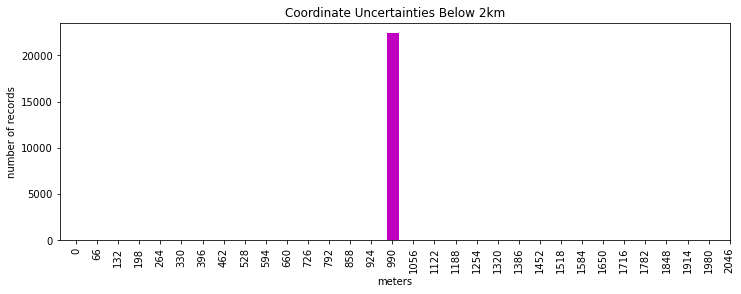

In [40]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("meters")
plt.title("Coordinate Uncertainties Below 2km")

#### Remarks

In [41]:
print("General remarks:")
remarks = output_db_conn.execute("SELECT DISTINCT general_remarks FROM occurrence_records;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

General remarks:
nan


In [42]:
print("Event remarks:")
remarks = output_db_conn.execute("SELECT DISTINCT eventRemarks FROM occurrence_records;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

Event remarks:
nan


In [43]:
print("Occurrence remarks:")
remarks = output_db_conn.execute("SELECT DISTINCT occurrenceRemarks FROM occurrence_records;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

Occurrence remarks:
nan
Need headphones to properly hear this call - it's a soft, rapid, repetitive cooing sound. In the second audio file, you'll hear a red-bellied woodpecker and my phone vibrating. This bird call is much quieter than those sounds. I believe it's a bird, but not sure. Closest match I could find is ground dove (Columbina passerina), but I think it's not that species - the call is too rapid a little different in pitch. Help - it's driving me crazy, been hearing it for weeks now. Yesterday I'm pretty sure I heard a call-and-response from two of these. Both were located near small creeks through young, mixed hardwood forest.
Adults and juveniles in trees above the Goose Overlook Observation deck
on nest
recently fledged juvenile
Window kill
Yellow-billed Cuckoo Washington County, Florida 7-15-11


In [44]:
print("Location remarks:")
remarks = output_db_conn.execute("SELECT DISTINCT locationRemarks FROM occurrence_records;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

Location remarks:
nan


In [45]:
print("Identified remarks:")
remarks = output_db_conn.execute("SELECT DISTINCT general_remarks FROM occurrence_records;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

Identified remarks:
nan


In [46]:
print("Georeference remarks:")
remarks = output_db_conn.execute("SELECT DISTINCT georeferenceRemarks FROM occurrence_records;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

Georeference remarks:
nan


## Citations
#### eBird 

In [47]:
if ask_eBird == True:
    with open(config.EBD_file[:-22] + "recommended_citation.txt", "r") as reference:
        print(reference.readlines()[0])
else:
    print("No eBird Basic Dataset was queried")

No eBird Basic Dataset was queried


#### GBIF

In [48]:
if ask_GBIF == True:
    if get_dwca == True:
        print("Citations-- ")
        print(cursor.execute("SELECT citations FROM GBIF_download_info").fetchall()[0][0])
    else:
        print("Set 'get_dwca' to True to acquire a list of citations")
if ask_GBIF == False:
    print("GBIF was not queried.")

Citations-- 
When using this dataset please use the following citation and pay attention to the rights documented in rights.txt:
Vellinga W (2021). Xeno-canto - Bird sounds from around the world. Xeno-canto Foundation for Nature Sounds. Occurrence dataset https://doi.org/10.15468/qv0ksn accessed via GBIF.org on 2021-06-08.
Ueda K (2021). iNaturalist Research-grade Observations. iNaturalist.org. Occurrence dataset https://doi.org/10.15468/ab3s5x accessed via GBIF.org on 2021-06-08.
Levatich T, Ligocki S (2020). EOD - eBird Observation Dataset. Cornell Lab of Ornithology. Occurrence dataset https://doi.org/10.15468/aomfnb accessed via GBIF.org on 2021-06-08.



In [49]:
if ask_GBIF == True:
    if get_dwca == True:
        print("Rights-- ")
        print(output_db_conn.execute("SELECT rights FROM GBIF_download_info").fetchall()[0][0])
    else:
        print("Set 'get_dwca' to True to see the rights")
if ask_GBIF == False:
    print("GBIF was not queried.")

Rights-- 

Dataset: Xeno-canto - Bird sounds from around the world
Rights as supplied: http://creativecommons.org/licenses/by-nc/4.0/legalcode
Dataset: iNaturalist Research-grade Observations
Rights as supplied: http://creativecommons.org/licenses/by-nc/4.0/legalcode
Dataset: EOD - eBird Observation Dataset
Rights as supplied: http://creativecommons.org/publicdomain/zero/1.0/legalcode


In [50]:
if ask_GBIF == True:
    if get_dwca == True:
        print("DOI-- ")
        doi = output_db_conn.execute("SELECT doi FROM GBIF_download_info").fetchall()[0][0]
        print("https://doi.org/" + doi)
    else:
        print("Set 'get_dwca' to True to perform a search with a doi assigned")
if ask_GBIF == False:
    print("GBIF was not queried.")

DOI-- 
https://doi.org/10.15468/dl.net434


In [51]:
if ask_GBIF == True:
    if get_dwca == True:
        print("GBIF download key-- ")
        print(output_db_conn.execute("SELECT download_key FROM GBIF_download_info").fetchall()[0][0])
    else:
        print("Set 'get_dwca' to True to perform a search with a download key assigned")
if ask_GBIF == False:
    print("GBIF was not queried")

GBIF download key-- 
0297512-200613084148143


## Runtime

In [52]:
output_db_conn.close()
del cursor
t2 = datetime.now()
print(t2 - t1)

0:45:19.439509


In [55]:
import importlib
importlib.reload(functions)
functions.verify_results(output_database)